In [1]:
#created by Alex Schueth, graduate research assistant at Texas Tech University
#last updated 6/6/2017
#For questions, please contact at alex.schueth@ttu.edu

import matplotlib
matplotlib.use('agg')
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
import matplotlib.colors as colors
import numpy.ma as ma
from metpy.plots import ctables
import scipy.ndimage as ndimage
from scipy.interpolate import interp1d
from datetime import datetime
import cmocean
import operator
import gc
import scipy
% matplotlib inline

/home/adixon/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
#I am in love with this colormap so I included it
def sftemp():
    sfc_cdict ={'red':      ((0.00, 0.20, 0.20),
                             (0.08, 0.40, 0.40),
                             (0.17, 0.27, 0.27),
                             (0.25, 0.80, 0.80),
                             (0.33, 0.20, 0.20),
                             (0.42, 0.20, 0.20),
                             (0.50, 0.00, 0.00),
                             (0.58, 0.99, 0.99),
                             (0.67, 1.00, 1.00),
                             (0.75, 0.82, 0.82),
                             (0.83, 0.53, 0.53),
                             (0.92, 0.95, 0.95),
                             (1.00, 1.00, 1.00)),
        
        'green':        ((0.00, 0.20, 0.20),
                         (0.08, 0.40, 0.40),
                         (0.17, 0.00, 0.00),
                         (0.25, 0.60, 0.60),
                         (0.33, 0.40, 0.40),
                         (0.42, 0.60, 0.60),
                         (0.50, 0.39, 0.39),
                         (0.58, 0.76, 0.76),
                         (0.67, 0.36, 0.36),
                         (0.75, 0.02, 0.02),
                         (0.83, 0.00, 0.00),
                         (0.92, 0.03, 0.03),
                         (1.00, 0.60, 0.60)),
            
            'blue':         ((0.00, 0.60, 0.60),
                             (0.08, 0.60, 0.60),
                             (0.17, 0.65, 0.65),
                             (0.25, 1.00, 1.00),
                             (0.33, 1.00, 1.00),
                             (0.42, 0.40, 0.40),
                             (0.50, 0.07, 0.07),
                             (0.58, 0.02, 0.02),
                             (0.67, 0.00, 0.00),
                             (0.75, 0.01, 0.01),
                             (0.83, 0.00, 0.00),
                             (0.92, 0.52, 0.52),
                             (1.00, 0.80, 0.80))}
                

    sfc_coltbl = LinearSegmentedColormap('SFC_COLTBL',sfc_cdict)
    return sfc_coltbl
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [103]:
startTime = datetime.now() #to time how long it takes the script to run. Eventually to lead to optimization
    
x0,y0,z0 = 2, -4, 0. #kilometers from the origin, aka where the radar is located
#x0,y0,z0 = -5, -5., 0. #kilometers from the origin, aka where the radar is located

RHIlength=7. #length of the RHI
dx=25. #horizontal grid spacing of the model used to calculate how many "bins" used to interpolate to
azimuth=155.
npts=RHIlength/(dx/1000)

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

for enum,f in enumerate(range(450,451)): #looping through files
    #-----------------------------------------------------------------------------------

    radar_levels = [x/10. for x in range(-50,651)]
    tvlevels = [x / 10. for x in range(0,51,1)]

    filename = 'nc-ff.05550.000000.nc'
    print(filename)
    a = Dataset(filename, 'r')

print(a.variables.keys())    

nc-ff.05550.000000.nc
odict_keys(['xh', 'yh', 'zh', 'zf', 'time', 'X0', 'Y0', 'X1', 'Y1', 'Z0', 'Z1', 'dbz', 'thrhopert', 'prespert', 'uinterp', 'vinterp', 'winterp', 'xvort', 'yvort', 'zvort', 'xvort_baro', 'xvort_tilt', 'xvort_stretch', 'yvort_baro', 'yvort_tilt', 'yvort_stretch', 'zvort_tilt', 'zvort_stretch', 'hvort', 'vortmag', 'streamvort'])


In [104]:
    time = a.variables["time"][0]

    u = a.variables["uinterp"][0,:,:,:]#use actual winds not storm-relative winds 
    v = a.variables["vinterp"][0,:,:,:]
    w = a.variables["winterp"][0,:,:,:]

    zvort = a.variables["zvort"][0,:,:,:]
    yvort = a.variables["yvort"][0,:,:,:]
    xvort = a.variables["xvort"][0,:,:,:]

    x=a.variables["xh"][:]
    y=a.variables["yh"][:]
    z=a.variables["zh"][:] 

    wndspd=np.sqrt(u**2+v**2+w**2)
    svort=a.variables['streamvort'][0,:,:,:]

    ref=a.variables["dbz"][0,:,:]
    theta = a.variables["thrhopert"][0,:,:,:]
    ppert = a.variables["prespert"][0,:,:,:]

    zgradtv, ygradtv, xgradtv=np.gradient(theta[:,:,:])
    maggradtv=np.sqrt((xgradtv)**2.+(ygradtv)**2+(zgradtv)**2)

    a.close()

    dudy,dudx=np.array(np.gradient(u,dx,axis=(1,2)))
    dvdy,dvdx=np.array(np.gradient(v,dx,axis=(1,2)))
    dwdy,dwdx=np.array(np.gradient(w,dx,axis=(1,2)))
    dtdy,dtdx=np.array(np.gradient(theta,dx,axis=(1,2)))

    Delt=np.sqrt(dtdx**2+dtdy**2)#+dtdz**2)

    adia2dfronto=(1./Delt)*(dtdx*(-dudx*dtdx-dvdx*dtdy)+dtdy*(-dudy*dtdx-dvdy*dtdy))*1000.#+dtdz*(-dudz*dtdx-dvdz*dtdy-dwdz*dtdz))*1000.   haven't figured out 3d fronto yet
    adia2dfronto=np.nan_to_num(adia2dfronto)#replaces nans with zero's so interpolati    plt.plot([x0,x1cross],[y0,y1cross],color="black")on won't fail.

    #takes care of the special cases of geometry
    if azimuth >=0. and azimuth < 90.:
        uproj=u*(1.-np.sin(np.deg2rad(azimuth)))
        vproj=v*(1.-np.cos(np.deg2rad(azimuth)))
        xvortproj=xvort*(1.-np.cos(np.deg2rad(azimuth)))
        yvortproj=yvort*(1.-np.sin(np.deg2rad(azimuth)))
    if azimuth >= 90. and azimuth < 180.:
        uproj=-u*(1.-np.sin(np.deg2rad(azimuth)))
        vproj=v*(1.-np.cos(np.deg2rad(180-azimuth)))
        xvortproj=-xvort*(1.-np.cos(np.deg2rad(azimuth)))
        yvortproj=yvort*(1.-np.sin(np.deg2rad(180-azimuth)))
    if azimuth >= 180. and azimuth < 270.:
        uproj=-u*(1.-np.sin(np.deg2rad(360-azimuth)))
        vproj=-v*(1.-np.cos(np.deg2rad(180-azimuth)))
        xvortproj=-xvort*(1.-np.cos(np.deg2rad(360-azimuth)))
        yvortproj=-yvort*(1.-np.sin(np.deg2rad(180-azimuth)))
    if azimuth >= 270. and azimuth <360.:
        uproj=u*(1.-np.sin(np.deg2rad(360-azimuth)))
        vproj=-v*(1.-np.cos(np.deg2rad(azimuth)))
        xvortproj=xvort*(1.-np.cos(np.deg2rad(360-azimuth)))
        yvortproj=-yvort*(1.-np.sin(np.deg2rad(azimuth)))

    # xplot = np.zeros((len(z),int(npts)))
    # for vertical in range(len(z)):
    xplot=np.linspace(0.,RHIlength,npts)

    crosswind=np.zeros((len(z),int(npts)))
    crossref=np.zeros((len(z),int(npts)))
    crosstvp=np.zeros((len(z),int(npts)))
    crosstvgrad=np.zeros((len(z),int(npts)))
    crossfronto=np.zeros((len(z),int(npts)))
    crosssvortmag=np.zeros((len(z),int(npts)))
    crossppert=np.zeros((len(z),int(npts)))

    #finds the final position for the cross section
    x1cross=x0+RHIlength*np.cos(np.deg2rad(azimuth))
    y1cross=y0+RHIlength*np.sin(np.deg2rad(azimuth))

    crossx = np.linspace(x0,x1cross,npts)
    crossy = np.linspace(y0,y1cross,npts)
    crossxinterp=interp1d(x,np.arange(len(x)))
    crossyinterp=interp1d(y,np.arange(len(y)))
    crossxk = crossxinterp(crossx)
    crossyk = crossyinterp(crossy)

    for k in range(0, len(z)): 
        crosswind[k,:]= scipy.ndimage.map_coordinates(uproj[k,:,:]+vproj[k,:,:], np.vstack((crossyk, crossxk))) #adds the projection of the u component on the desired plane and the projection of the v component on the desired plane together
        crosssvortmag[k,:]= scipy.ndimage.map_coordinates(svort[k,:,:], np.vstack((crossyk, crossxk))) #scipy.ndimage.map_coordinates(xvortproj[k,:,:]+yvortproj[k,:,:], np.vstack((crossyk, crossxk)))
        crossref[k,:]= scipy.ndimage.map_coordinates(ref[k,:,:], np.vstack((crossyk, crossxk)))
        crosstvp[k,:]= scipy.ndimage.map_coordinates(theta[k,:,:], np.vstack((crossyk, crossxk)))
        crosstvgrad[k,:]= scipy.ndimage.map_coordinates(maggradtv[k,:,:], np.vstack((crossyk, crossxk)))
        crossfronto[k,:]= scipy.ndimage.map_coordinates(adia2dfronto[k,:,:], np.vstack((crossyk, crossxk)))
        crossppert[k,:]= scipy.ndimage.map_coordinates(ppert[k,:,:], np.vstack((crossyk, crossxk)))

    # vel_levels=range(-40,40+1,1)

    #plotting

    fig = plt.figure(figsize=(30, 15))
    ref_norm, ref_cmap = ctables.registry.get_with_range('NWSStormClearReflectivity', -5, 65)
    ref_new_cmap = truncate_colormap(ref_cmap, 0.25,1.02)
    vel_cmap = truncate_colormap(ctables.registry.get_colortable('Carbone42'), 0,1)

    #row,column
    ax1 = plt.subplot2grid((3,3),(0,0),rowspan=2)
    radar=plt.contourf(x,y,ref[0,:,:],radar_levels,cmap=ref_new_cmap, norm=ref_norm)
    plt.plot([x0,x1cross],[y0,y1cross],color="black")
    plt.plot(x0,y0,'ko', markersize=8)
    plt.plot(x0,y0,'wo', markersize=5)
    plt.colorbar(radar, label="Radar Reflectivity [dBZ]", ticks=[-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65])
    plt.xlabel('Kilometers')
    plt.ylabel('Kilometers')
    plt.title('Model Time: '+str(int(time))+' seconds')

    ax2 = plt.subplot2grid((3,3),(2,0))
    pvort=ax2.pcolormesh(xplot,z,crosssvortmag,vmin=0,vmax=0.1)
    plt.colorbar(pvort, label="Streamwise Vorticity Magnitude [1/s]")#, ticks=[-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30])
    plt.title('Streamwise Vorticity Magnitude')
    plt.ylim(0, 4.5)
    plt.xlim(0, int(RHIlength))
    plt.grid(True)

    ax3 = plt.subplot2grid((3,3),(0,1))
    pref = ax3.pcolormesh(xplot,z,ma.array(crossref,mask=[crossref<-5]),cmap=ref_new_cmap, norm=ref_norm)
    plt.colorbar(pref, label="Radar Reflectivity [dBZ]", ticks=[-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65])
    plt.title('Reflectivity')
    plt.ylim(0, 4.5)
    plt.xlim(0, int(RHIlength))
    plt.grid('on')

    ax4 = plt.subplot2grid((3,3),(1,1))
    pvel=ax4.pcolormesh(xplot,z,crosswind,cmap=vel_cmap, vmin=-15, vmax=15)
    plt.colorbar(pvel, label="Velocity [m/s]", ticks=[-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15])
    plt.title('Radial Velocity')
    plt.ylim(0, 4.5)
    plt.xlim(0, int(RHIlength))
    plt.grid(True)

    ax5 = plt.subplot2grid((3,3),(2,1))
    pppert=ax5.pcolormesh(xplot,z,crossppert,cmap='hot',vmin=-20.,vmax=0.)
    plt.colorbar(pppert, label="Pressure Perturbation [hPa]")#, ticks=[-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])
    plt.title('Pressure Perturbation')
    plt.ylim(0, 4.5)
    plt.xlim(0, int(RHIlength))
    plt.grid(True)

    ax6 = plt.subplot2grid((3,3),(0,2))
    ptv=ax6.pcolormesh(xplot,z,crosstvp,cmap=sftemp(),vmin=-5,vmax=1)
    plt.colorbar(ptv, label="Perturbation Virtual Potential Temperature [K]")#, ticks=[-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30])
    plt.title('Perturbation Virtual Potential Temperature')
    plt.ylim(0, 4.5)
    plt.xlim(0, int(RHIlength))
    plt.grid(True)


    ax7 = plt.subplot2grid((3,3),(1,2))
    ptvgrad=ax7.pcolormesh(xplot,z,crosstvgrad,cmap=cmocean.cm.matter,vmin=0,vmax=2)
    plt.colorbar(ptvgrad, label="Virtual Portential Temperature Gradient [K]")#, ticks=[-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30])
    plt.title('Virtual Potential Temperature Gradient')
    plt.ylim(0, 4.5)
    plt.xlim(0, int(RHIlength))
    plt.grid(True)
    
    
    ax8 = plt.subplot2grid((3,3),(2,2))
    pfronto=ax8.pcolormesh(xplot,z,crossfronto,cmap='seismic',vmin=-0.25,vmax=0.25)
    plt.colorbar(pfronto, label="Adiabatic 2D Frontogenesis"+r'$[\frac{K}{km \cdot s}]$', ticks=[-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])
    plt.title('Adiabatic 2D Frontogenesis')
    plt.ylim(0, 4.5)
    plt.xlim(0, int(RHIlength))
    plt.grid(True)
    

    fig.suptitle('Simulated RHI     Azimuth: '+str(azimuth)+'     '+str(int(time))+' seconds', fontsize=20, y=1.00)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout(pad=3.0)#fixes the aspect ratio some

    ax1.set_rasterized(True)
    ax2.set_rasterized(True)
    ax3.set_rasterized(True)
    ax4.set_rasterized(True)
    
    ax5.set_rasterized(True)
    ax6.set_rasterized(True)
    ax7.set_rasterized(True)
    ax8.set_rasterized(True)

    plt.savefig('RHIstuff.png')
    plt.close()
    fig.clf()
    gc.collect()

    print("Plotting Time: "+str(datetime.now() - startTime))

/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply
/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/adixon/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/

Plotting Time: 0:00:34.694816


Traceback (most recent call last):
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py", line 957, in on_mappable_changed
    self.update_normal(mappable)
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py", line 987, in update_normal
    self.draw_all()
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py", line 353, in draw_all
    self._config_axes(X, Y)
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py", line 442, in _config_axes
    self.outline.remove()
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/matplotlib/artist.py", line 151, in remove
    self._remove_method(self)


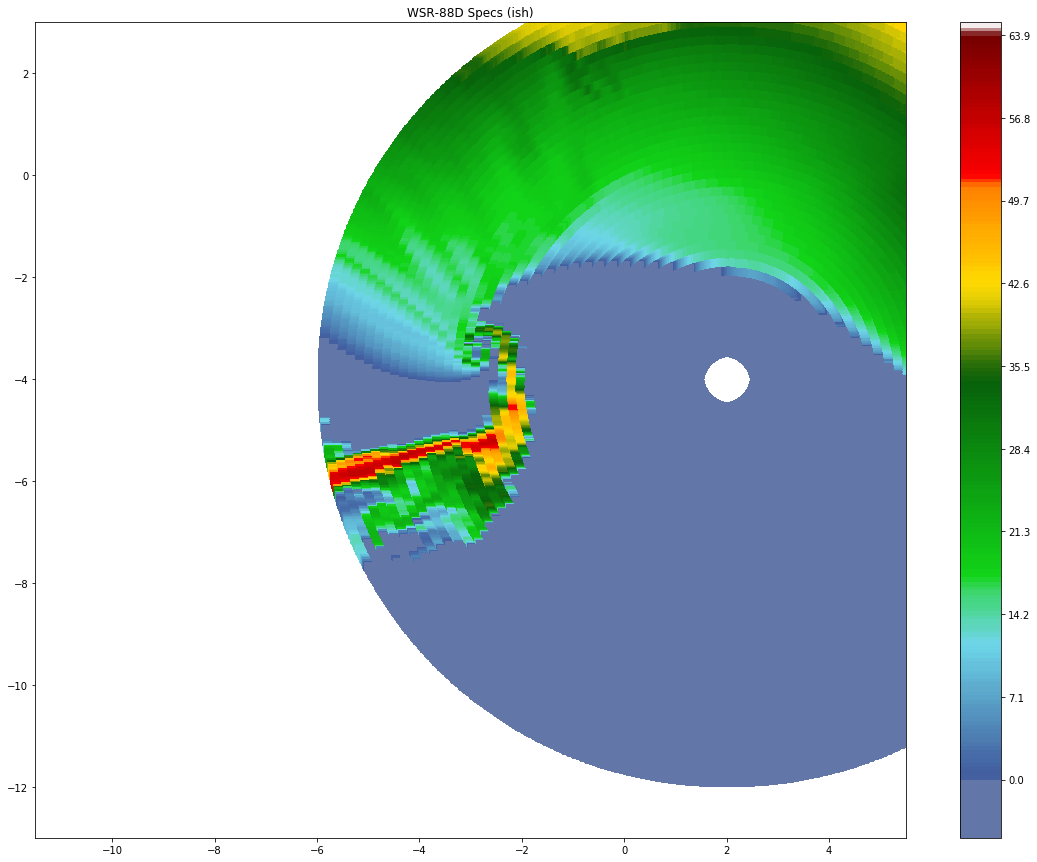

In [105]:
# Reflectivity PPI

r = np.arange(0.55,8.05,0.175)
from scipy.interpolate import spline
from scipy.interpolate import RegularGridInterpolator
interp3d = RegularGridInterpolator((z, y, x), ref, method="linear", bounds_error=False, fill_value=None)



for phi in np.arange(.5,60.5,1):
    fig = plt.figure(figsize=(19.5,15))
    plt.xlim(-10, 0)
    plt.ylim(-10, 6)
    for azimuth in np.arange(0,360, 0.25):
        x1cross=x0+r*np.cos(np.deg2rad(azimuth))
        y1cross=y0+r*np.sin(np.deg2rad(azimuth))
        zcross=r*np.tan(np.deg2rad(phi))
    
        line = []
        for xpt, ypt, zpt in zip(x1cross, y1cross, zcross):
            line.append(np.array([zpt, ypt, xpt]))
        line = np.array(line)
        linevalues = interp3d(line)
        
        #plt.subplot(2,1,1)
        ax = plt.scatter(x1cross, y1cross, c=linevalues, s=80, cmap=ref_new_cmap, vmin=0, vmax=65, marker='s', norm=ref_norm)
        ax.set_facecolor('k')
        plt.xlim(-11.5, 5.5)
        plt.ylim(-13, 3)
#         plt.subplot(2,1,2)
#         plt.scatter(x1cross, zcross, c=linevalues, s=8, cmap=vel_cmap, vmin=0, vmax=65, marker='s')
    
    plt.colorbar(radar)
    plt.title('WSR-88D Specs (ish)')
    plt.savefig('ppiattempt.png')
    plt.show()
    
    
    break
    




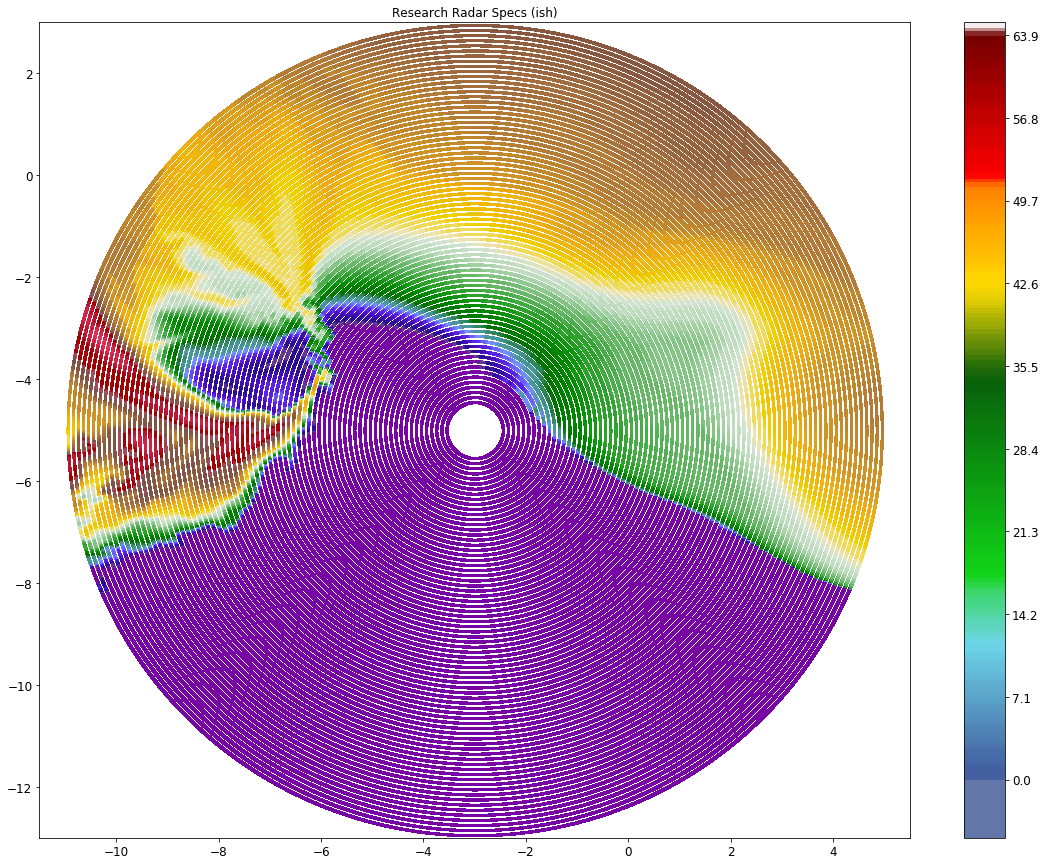

In [20]:
# High-res Reflectivity PPI

r = np.arange(0.55,8.05,0.1)
from scipy.interpolate import spline
from scipy.interpolate import RegularGridInterpolator
interp3d = RegularGridInterpolator((z, y, x), ref, method="linear", bounds_error=False, fill_value=None)



for phi in np.arange(.5,60.5,1):
    fig = plt.figure(figsize=(19.5,15))
    plt.xlim(-10, 0)
    plt.ylim(-10, 6)
    for azimuth in np.arange(0,360, 0.018):
        x1cross=x0+r*np.cos(np.deg2rad(azimuth))
        y1cross=y0+r*np.sin(np.deg2rad(azimuth))
        zcross=r*np.tan(np.deg2rad(phi))
    
        line = []
        for xpt, ypt, zpt in zip(x1cross, y1cross, zcross):
            line.append(np.array([zpt, ypt, xpt]))
        line = np.array(line)
        linevalues = interp3d(line)
        
        #plt.subplot(2,1,1)
        ax = plt.scatter(x1cross, y1cross, c=linevalues, s=5, cmap=vel_cmap, vmin=0, vmax=65, marker='s')
        ax.set_facecolor('k')
        plt.xlim(-11.5, 5.5)
        plt.ylim(-13, 3)
#         plt.subplot(2,1,2)
#         plt.scatter(x1cross, zcross, c=linevalues, s=8, cmap=vel_cmap, vmin=0, vmax=65, marker='s')
    
    plt.colorbar(radar)
    plt.title('Research Radar Specs (ish)')
    plt.savefig('hiresppiattempt.png')
    plt.show()
    
    
    break

/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


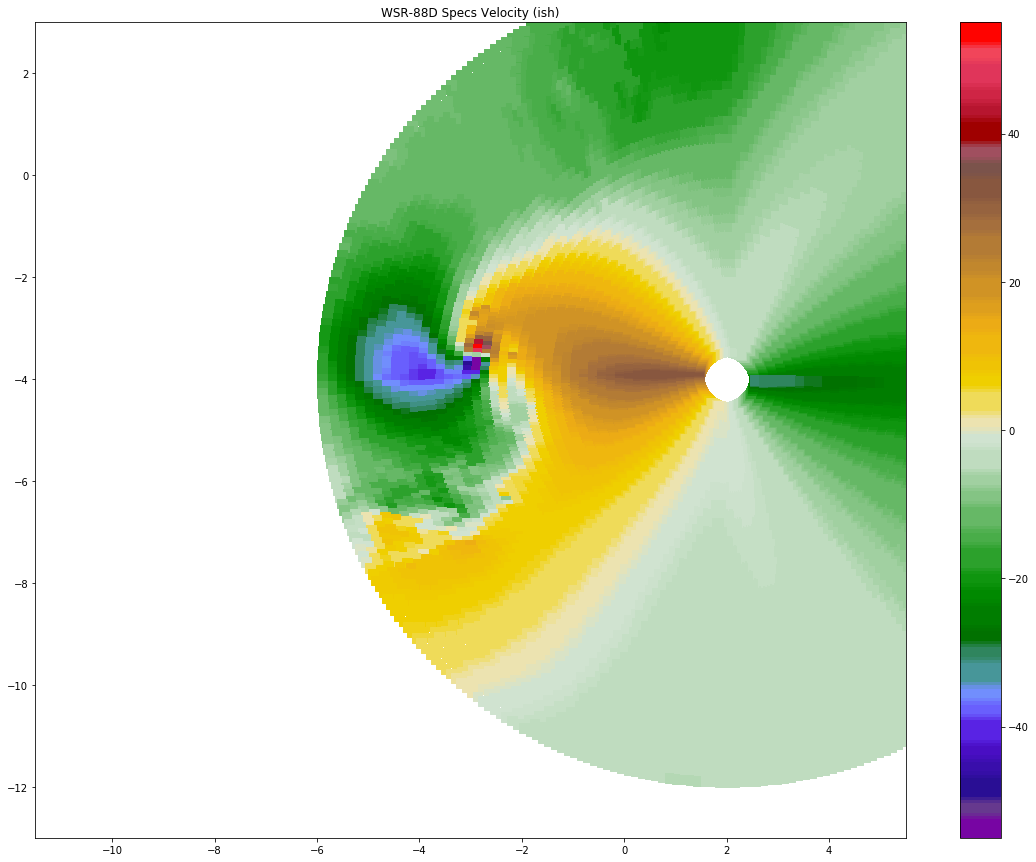

In [107]:
## Radial velocity PPI
#u = -20*np.ones(u.shape)
#v = 20*np.ones(v.shape)

# xplot = np.zeros((len(z),int(npts)))
# for vertical in range(len(z)):
xplot=np.linspace(0.,RHIlength,npts)

crosswind=np.zeros((len(z),int(npts)))

#finds the final position for the cross section
x1cross=x0+RHIlength*np.cos(np.deg2rad(azimuth))
y1cross=y0+RHIlength*np.sin(np.deg2rad(azimuth))
    
r = np.arange(0.55,8.05,0.175)
from scipy.interpolate import spline
from scipy.interpolate import RegularGridInterpolator

    
    
for phi in np.arange(.5,60.5,1):
    fig = plt.figure(figsize=(19.5,15))
    plt.xlim(-10, 0)
    plt.ylim(-10, 6)
    for azimuth in np.arange(0,360, 1):
        #Vr = u * np.sin(np.deg2rad(azimuth)) + v * np.cos(np.deg2rad(azimuth))
        if azimuth >=0. and azimuth < 90.:
            uproj=u*(1.-np.sin(np.deg2rad(azimuth)))
            vproj=v*(1.-np.cos(np.deg2rad(azimuth)))
            Vr = uproj + vproj
        if azimuth >= 90. and azimuth < 180.:
            uproj=-u*(1.-np.sin(np.deg2rad(azimuth)))
            vproj=v*(1.-np.cos(np.deg2rad(180-azimuth)))
            Vr = uproj + vproj
        if azimuth >= 180. and azimuth < 270.:
            uproj=-u*(1.-np.sin(np.deg2rad(360-azimuth)))
            vproj=-v*(1.-np.cos(np.deg2rad(180-azimuth)))
            Vr = uproj + vproj
        if azimuth >= 270. and azimuth <360.:
            uproj=u*(1.-np.sin(np.deg2rad(360-azimuth)))
            vproj=-v*(1.-np.cos(np.deg2rad(azimuth)))
            Vr = uproj + vproj
        interp3d = RegularGridInterpolator((z,y,x), Vr, method="linear", bounds_error=False, fill_value=None)
        x1cross=x0+r*np.cos(np.deg2rad(azimuth))
        y1cross=y0+r*np.sin(np.deg2rad(azimuth))
        zcross=r*np.tan(np.deg2rad(phi))

        line = []
        for xpt, ypt, zpt in zip(x1cross, y1cross, zcross):
                    line.append(np.array([zpt, ypt, xpt]))
        line = np.array(line)
        linevalues = interp3d(line)
        #print(linevalues[1])
        
        #plt.subplot(2,1,1)
        ax = plt.scatter(x1cross, y1cross, c=linevalues, s=95, vmin=-55, vmax=55, cmap=vel_cmap, marker='s')
        ax.set_facecolor('k')
        plt.xlim(-11.5, 5.5)
        plt.ylim(-13, 3)
#         plt.subplot(2,1,2)
#         plt.scatter(x1cross, zcross, c=linevalues, s=8, cmap=vel_cmap, vmin=0, vmax=65, marker='s')
    
    plt.colorbar()
    plt.title('WSR-88D Specs Velocity (ish)')
    plt.savefig('ppivelocity.png')
    plt.show()
    
    
    break



In [70]:
u = 20*np.ones(u.shape)
v = 20*np.ones(v.shape)
print(np.sqrt(20**2+20**2))


Vr = u * np.sin(np.deg2rad(45)) + v * np.cos(np.deg2rad(45))
print(Vr, Vr.max(), Vr.min())

28.2842712475
[[[ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  ..., 
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]]

 [[ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  ..., 
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.28427125
    28.28427125]
  [ 28.28427125  28.28427125  28.28427125 ...,  28.28427125  28.2842

In [37]:
linevalues

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [7]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    """
    In: 
    cmap, name 
    Out:
    my_cmap_r

    Explanation:
    t[0] goes from 0 to 1
    row i:   x  y0  y1 -> t[0] t[1] t[2]
                   /
                  /
    row i+1: x  y0  y1 -> t[n] t[1] t[2]

    so the inverse should do the same:
    row i+1: x  y1  y0 -> 1-t[0] t[2] t[1]
                   /
                  /
    row i:   x  y1  y0 -> 1-t[n] t[2] t[1]
    """        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = matplotlib.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r


vel_cmap_r = reverse_colourmap(vel_cmap, name = 'vel_cmap_r')

/Users/austindixonwx/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


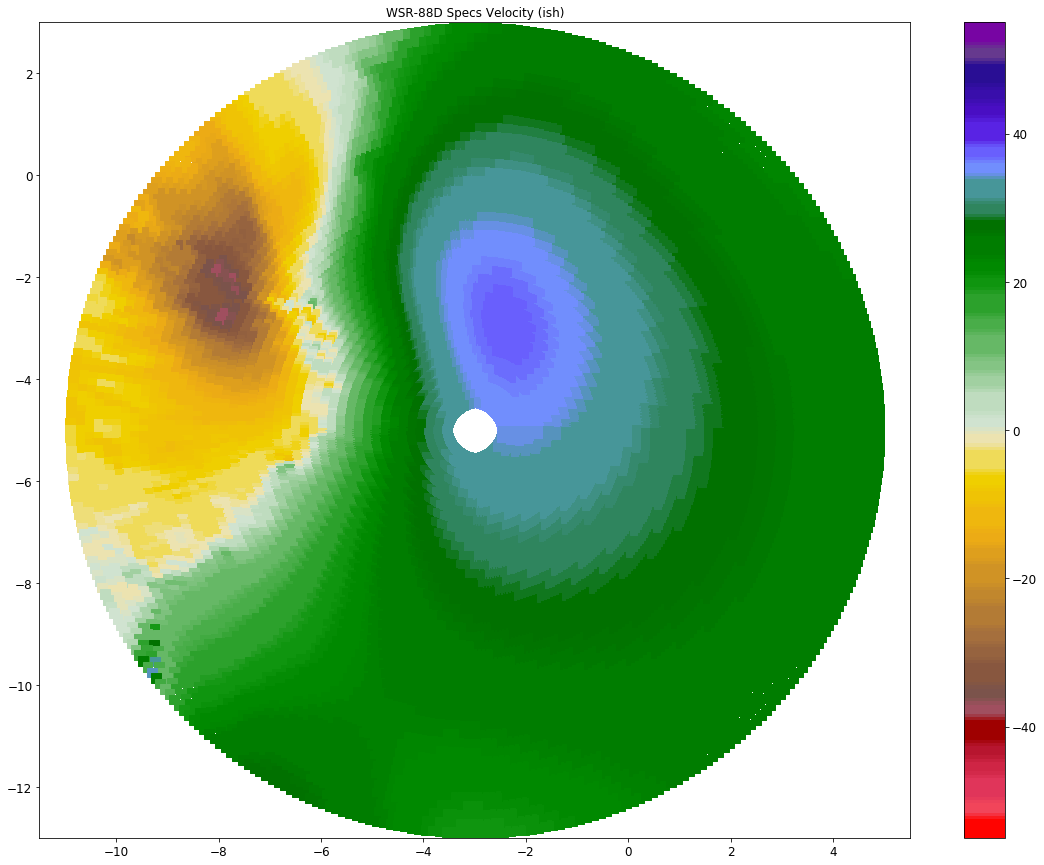

In [23]:
if azimuth >=0. and azimuth < 90.:
    uproj=u*(np.cos(np.deg2rad(azimuth)))
    vproj=v*(np.cos(np.deg2rad(90-azimuth)))
if azimuth >= 90. and azimuth < 180.:
    uproj=u*(np.cos(np.deg2rad(180-azimuth)))
    vproj=-v*(np.cos(np.deg2rad(azimuth-90)))
if azimuth >= 180. and azimuth < 270.:
    uproj=-u*(np.cos(np.deg2rad(azimuth-180)))
    vproj=-v*(np.cos(np.deg2rad(270-azimuth)))
if azimuth >= 270. and azimuth <360.:
    uproj=-u*(np.cos(np.deg2rad(360-azimuth)))
    vproj=v*(np.cos(np.deg2rad(azimuth-270)))

xplot=np.linspace(0.,RHIlength,npts)

#finds the final position for the cross section
x1cross=x0+RHIlength*np.cos(np.deg2rad(azimuth))
y1cross=y0+RHIlength*np.sin(np.deg2rad(azimuth))
    
r = np.arange(0.55,8.05,0.175)
from scipy.interpolate import spline
from scipy.interpolate import RegularGridInterpolator
interp3d = RegularGridInterpolator((z,y,x), uproj+vproj  , method="linear", bounds_error=False, fill_value=None)
    
    
for phi in np.arange(.5,60.5,1):
    fig = plt.figure(figsize=(19.5,15))
    plt.xlim(-10, 0)
    plt.ylim(-10, 6)
    for azimuth in np.arange(0,360, 1):
        x1cross=x0+r*np.cos(np.deg2rad(azimuth))
        y1cross=y0+r*np.sin(np.deg2rad(azimuth))
        zcross=r*np.tan(np.deg2rad(phi))
    
        line = []
        for xpt, ypt, zpt in zip(x1cross, y1cross, zcross):
                    line.append(np.array([zpt, ypt, xpt]))
        line = np.array(line)
        linevalues = interp3d(line)
        
        #plt.subplot(2,1,1)
        ax = plt.scatter(x1cross, y1cross, c=linevalues, s=95, vmin=-55, vmax=55, cmap=vel_cmap_r, marker='s')
        ax.set_facecolor('k')
        plt.xlim(-11.5, 5.5)
        plt.ylim(-13, 3)
#         plt.subplot(2,1,2)
#         plt.scatter(x1cross, zcross, c=linevalues, s=8, cmap=vel_cmap, vmin=0, vmax=65, marker='s')
    
    plt.colorbar()
    plt.title('WSR-88D Specs Velocity (ish)')
    plt.savefig('ppivelocity.png')
    plt.show()
    
    
    break


/Users/austindixonwx/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


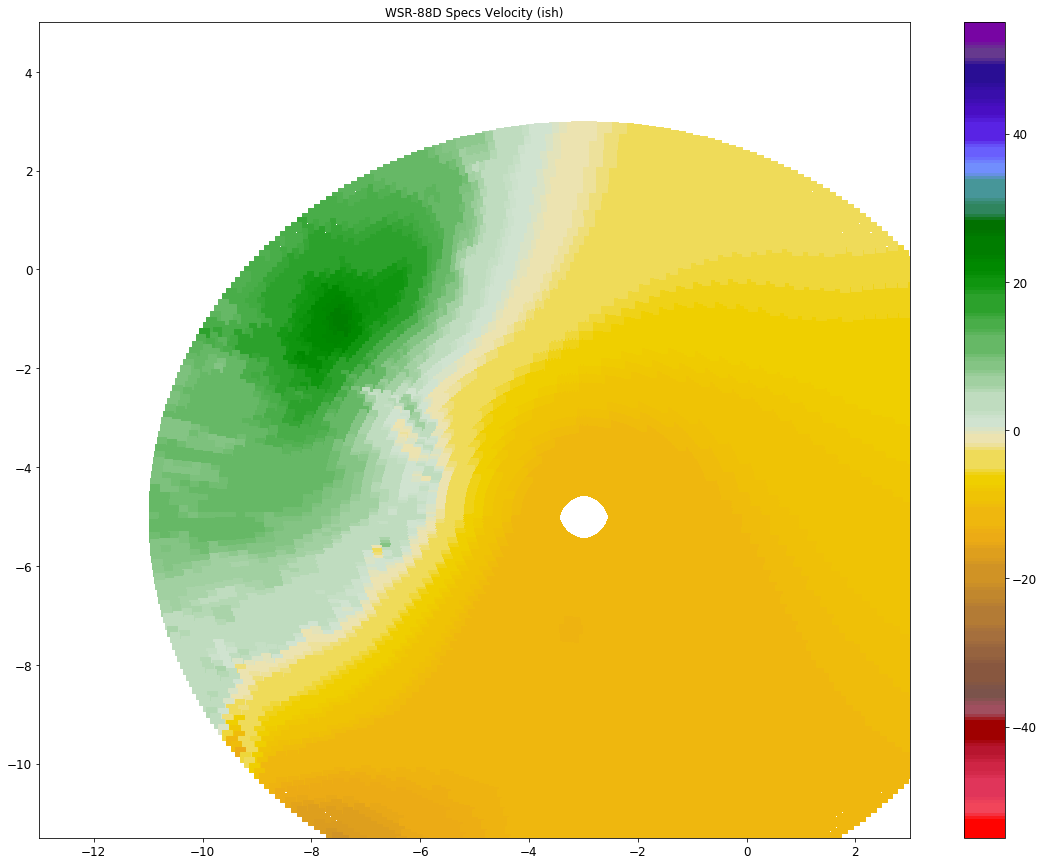

In [33]:
#unew = np.full((101, 764, 708), 25)
#vnew = np.full((101, 764, 708), 10)
uh25=uh[find_nearest(z,2):find_nearest(z,5),:,:]
print(find_nearest(z,2))
labelsmaxw,numlabelsmaxw=ndimage.label(gaussian_filter(uh25,sigma=50)>(0.75*np.amax(gaussian_filter(uh25,sigma=50))))
biggest=label_count(labelsmaxw)
mask=np.zeros_like(labelsmaxw)
mask[labelsmaxw==biggest[0]]=1

centroids=ndimage.measurements.center_of_mass(mask)

x0=x[int(centroids[2]+52)]
y0=y[int(centroids[1])]



if azimuth >=0. and azimuth < 90.:
    uproj=(u*(np.cos(np.deg2rad(azimuth))))*np.cos(np.deg2rad(azimuth))
    vproj=(v*(np.cos(np.deg2rad(azimuth))))*np.cos(np.deg2rad(azimuth))
if azimuth >= 90. and azimuth < 180.:
    uproj=(-u*(np.cos(np.deg2rad(azimuth))))*np.cos(np.deg2rad(azimuth))
    vproj=(v*(np.cos(np.deg2rad(180-azimuth))))*np.cos(np.deg2rad(180-azimuth))
if azimuth >= 180. and azimuth < 270.:
    uproj=(-u*(np.cos(np.deg2rad(360-azimuth))))*np.cos(np.deg2rad(360-azimuth))
    vproj=(-v*(np.cos(np.deg2rad(180-azimuth))))*np.cos(np.deg2rad(180-azimuth))
if azimuth >= 270. and azimuth <360.:
    uproj=(u*(np.cos(np.deg2rad(360-azimuth))))*np.cos(np.deg2rad(360-azimuth))
    vproj=(-v*(np.cos(np.deg2rad(azimuth))))*np.cos(np.deg2rad(azimuth))

xplot=np.linspace(0.,RHIlength,npts)

#finds the final position for the cross section
x1cross=x0+RHIlength*np.cos(np.deg2rad(azimuth))
y1cross=y0+RHIlength*np.sin(np.deg2rad(azimuth))
    
r = np.arange(0.55,8.05,0.175)
from scipy.interpolate import spline
from scipy.interpolate import RegularGridInterpolator
interp3d = RegularGridInterpolator((z,y,x), uproj+vproj, method="linear", bounds_error=False, fill_value=None)
    
    
for phi in np.arange(.5,60.5,1):
    fig = plt.figure(figsize=(19.5,15))
    plt.xlim(-10, 0)
    plt.ylim(-10, 6)
    for azimuth in np.arange(0,360, 1):
        x1cross=x0+r*np.cos(np.deg2rad(azimuth))
        y1cross=y0+r*np.sin(np.deg2rad(azimuth))
        zcross=r*np.tan(np.deg2rad(phi))
    
        line = []
        for xpt, ypt, zpt in zip(x1cross, y1cross, zcross):
                    line.append(np.array([zpt, ypt, xpt]))
        line = np.array(line)
        linevalues = interp3d(line)
        
        #plt.subplot(2,1,1)
        ax = plt.scatter(x1cross, y1cross, c=linevalues, s=95, vmin=-55, vmax=55, cmap=vel_cmap_r, marker='s')
        ax.set_facecolor('k')
        plt.xlim(-13, 5.5)
        plt.ylim(-13, 3)
    
    plt.colorbar()
    plt.title('WSR-88D Specs Velocity (ish)')
    plt.savefig('ppivelocity.png')
    plt.show()
    
    
    break

In [18]:
import matplotlib
matplotlib.use('agg')
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage
from scipy.interpolate import interp1d
from datetime import datetime
from matplotlib.colors import Normalize
from metpy.plots import ctables
import numpy.ma as ma
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter
import cmocean
import operator
import gc
import matplotlib.patheffects as PathEffects

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def sftemp():
    sfc_cdict ={'red':      ((0.00, 0.20, 0.20),
                             (0.08, 0.40, 0.40),
                             (0.17, 0.27, 0.27),
                             (0.25, 0.80, 0.80),
                             (0.33, 0.20, 0.20),
                             (0.42, 0.20, 0.20),
                             (0.50, 0.00, 0.00),
                             (0.58, 0.99, 0.99),
                             (0.67, 1.00, 1.00),
                             (0.75, 0.82, 0.82),
                             (0.83, 0.53, 0.53),
                             (0.92, 0.95, 0.95),
                             (1.00, 1.00, 1.00)),

        'green':        ((0.00, 0.20, 0.20),
                         (0.08, 0.40, 0.40),
                         (0.17, 0.00, 0.00),
                         (0.25, 0.60, 0.60),
                         (0.33, 0.40, 0.40),
                         (0.42, 0.60, 0.60),
                         (0.50, 0.39, 0.39),
                         (0.58, 0.76, 0.76),
                         (0.67, 0.36, 0.36),
                         (0.75, 0.02, 0.02),
                         (0.83, 0.00, 0.00),
                         (0.92, 0.03, 0.03),
                         (1.00, 0.60, 0.60)),

            'blue':         ((0.00, 0.60, 0.60),
                             (0.08, 0.60, 0.60),
                             (0.17, 0.65, 0.65),
                             (0.25, 1.00, 1.00),
                             (0.33, 1.00, 1.00),
                             (0.42, 0.40, 0.40),
                             (0.50, 0.07, 0.07),
                             (0.58, 0.02, 0.02),
                             (0.67, 0.00, 0.00),
                             (0.75, 0.01, 0.01),
                             (0.83, 0.00, 0.00),
                             (0.92, 0.52, 0.52),
                             (1.00, 0.80, 0.80))}


    sfc_coltbl = LinearSegmentedColormap('SFC_COLTBL',sfc_cdict)
    return sfc_coltbl
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

radar_levels = [x/10. for x in range(0,651)]
tvlevels = [x / 10. for x in range(0,51)]

startTime = datetime.now()

# x0,y0,z0 = 1., 4., 0. #kilometers from the origin, aka where the radar is located
z0=0.
# azimuth=120.
RHIlength=11. #length of the RHI
bins=1000. #This is the number of points along the line, "bins" if you will, bin length 10-15 m in the Ka
zenithres=0.3 #angle resolution in degrees, this is the correct resolution of the Ka
zenithmax=20.1 #max angle of the RHI
azimuthmin=150.
azimuthmax=160.
# startfile=0
#fil=250 #file number
# path='D:\\'
# path='G:\\'

def label_count(array_label):
    unique, counts = np.unique(array_label, return_counts=True)
    dicounts=(dict(zip(unique, counts)))
    dicountsorted = sorted(dicounts.items(), key=operator.itemgetter(1),reverse=True)
    idbiggest= [i[0] for i in dicountsorted[1:]]
    sizebiggest= [i[1] for i in dicountsorted[1:]]
    return np.array(idbiggest)

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

centroidslice=np.empty([750,3])


filename = 'nc-ff.03480.000000.nc'
print(filename)
a = Dataset(filename, 'r')

time = a.variables["time"][0]

u = a.variables["uinterp"][0,:,:,:]+11.
v = a.variables["vinterp"][0,:,:,:]+4.
w = a.variables["winterp"][0,:,:,:]

ref=a.variables["dbz"][0,:,:,:]

zvort = a.variables["zvort"][0,:,:,:]
yvort = a.variables["yvort"][0,:,:,:]
xvort = a.variables["xvort"][0,:,:,:]
# vortmag = np.sqrt(xvort**2+yvort**2)
wndspd=np.sqrt(u**2+v**2+w**2)
svortmag=(u*xvort+v*yvort+w*zvort)/wndspd

uh=w*zvort

x=a.variables["xh"][:]
y=a.variables["yh"][:]
z=a.variables["zh"][:]

theta = a.variables["thrhopert"][0,:,:,:]
ppert = a.variables["prespert"][0,:,:,:]/100.

zgradtvp, ygradtvp, xgradtvp=np.gradient(theta[:,:,:])
maggradtvp=np.sqrt((xgradtvp)**2.+(ygradtvp)**2+(zgradtvp)**2)

zgradtv, ygradtv, xgradtv=np.gradient(theta[:,:,:])
maggradtv=np.sqrt((xgradtv)**2.+(ygradtv)**2+(zgradtv)**2)

a.close()

#---------algo to find the location of the radar that is storm relative. should work for the most part, may need some tweaking
uh25=uh[find_nearest(z,2):find_nearest(z,5),:,:]
print(find_nearest(z,2))
labelsmaxw,numlabelsmaxw=ndimage.label(gaussian_filter(uh25,sigma=50)>(0.75*np.amax(gaussian_filter(uh25,sigma=50))))
biggest=label_count(labelsmaxw)
mask=np.zeros_like(labelsmaxw)
mask[labelsmaxw==biggest[0]]=1

centroids=ndimage.measurements.center_of_mass(mask)

x0=x[int(centroids[2]+52)]
y0=y[int(centroids[1])]

#-------------

for azimuth in range(int(azimuthmin),int(azimuthmax),10):

    #takes care of the special cases of geometry
    if azimuth >=0. and azimuth < 90.:
        uproj=u*(1.-np.sin(np.deg2rad(azimuth)))
        vproj=v*(1.-np.cos(np.deg2rad(azimuth)))
        xvortproj=xvort*(1.-np.cos(np.deg2rad(azimuth)))
        yvortproj=yvort*(1.-np.sin(np.deg2rad(azimuth)))
    if azimuth >= 90. and azimuth < 180.:
        uproj=-u*(1.-np.sin(np.deg2rad(azimuth)))
        vproj=v*(1.-np.cos(np.deg2rad(180-azimuth)))
        xvortproj=-xvort*(1.-np.cos(np.deg2rad(azimuth)))
        yvortproj=yvort*(1.-np.sin(np.deg2rad(180-azimuth)))
    if azimuth >= 180. and azimuth < 270.:
        uproj=-u*(1.-np.sin(np.deg2rad(360-azimuth)))
        vproj=-v*(1.-np.cos(np.deg2rad(180-azimuth)))
        xvortproj=-xvort*(1.-np.cos(np.deg2rad(360-azimuth)))
        yvortproj=-yvort*(1.-np.sin(np.deg2rad(180-azimuth)))
    if azimuth >= 270. and azimuth <360.:
        uproj=u*(1.-np.sin(np.deg2rad(360-azimuth)))
        vproj=-v*(1.-np.cos(np.deg2rad(azimuth)))
        xvortproj=xvort*(1.-np.cos(np.deg2rad(360-azimuth)))
        yvortproj=-yvort*(1.-np.sin(np.deg2rad(azimuth)))


    zenith = np.arange(zenithmax/zenithres+1)*zenithres
    xplot = np.zeros((len(zenith),int(bins)))
    zplot = np.zeros((len(zenith),int(bins)))
    rhiwind=np.zeros((len(zenith),int(bins)))
    rhiref=np.zeros((len(zenith),int(bins)))
    rhitvp=np.zeros((len(zenith),int(bins)))
    rhitvpgrad=np.zeros((len(zenith),int(bins)))
    rhifronto=np.zeros((len(zenith),int(bins)))
    rhiw=np.zeros((len(zenith),int(bins)))
    # rhivortmag=np.zeros((len(zenith),int(bins)))
    rhisvortmag=np.zeros((len(zenith),int(bins)))
    rhivortnorm=np.zeros((len(zenith),int(bins)))
    rhippert=np.zeros((len(zenith),int(bins)))

    for iteration, zen in enumerate(zenith):

        #the distance value of the end of the RHI
        x1=x0+(RHIlength*np.cos(np.deg2rad(azimuth))*np.cos(np.deg2rad(zen)))
        y1=y0+(RHIlength*np.sin(np.deg2rad(azimuth))*np.cos(np.deg2rad(zen)))
        z1=z0+(RHIlength*np.sin(np.deg2rad(zen)))

        #similar to the distance value arrays above, but these are to plot the data
        xplot[iteration,:]=np.linspace(0.,np.sqrt(np.abs(x1-x0)**2+np.abs(y1-y0)**2),bins)
        zplot[iteration,:]=np.linspace(z0,z1,bins)

        #interpolates the distances to the indices
        xinterp=interp1d(x,np.arange(len(x)), fill_value='extrapolate')
        yinterp=interp1d(y,np.arange(len(y)), fill_value='extrapolate')
        zinterp=interp1d(z,np.arange(len(z)),bounds_error=False,fill_value=0.0)#takes care of the situation where the lowest level is below the lowest grid point so it can't interpolate

        #find the decimal indices where the rhix values exist, these indices is where the image mapping is going to take place
        rhixi = xinterp(np.linspace(x0,x1,bins))
        rhiyi = yinterp(np.linspace(y0,y1,bins))
        rhizi = zinterp(np.linspace(z0,z1,bins))

        #first input is the full three dimensional data array
        #second input is the indices of the data array where the observations should be
        rhiwind[iteration,:]= ndimage.map_coordinates(uproj*np.cos(np.deg2rad(zen))+vproj*np.cos(np.deg2rad(zen))-w*np.sin(np.deg2rad(zen)), [rhizi,rhiyi,rhixi]) #adds the projection of the u component on the desired plane and the projection of the v component on the desired plane together
        rhiref[iteration,:]= ndimage.map_coordinates(ref[:,:,:], [rhizi,rhiyi,rhixi])
        rhitvp[iteration,:]= ndimage.map_coordinates(theta[:,:,:], [rhizi,rhiyi,rhixi])
        rhitvpgrad[iteration,:]= ndimage.map_coordinates(maggradtvp[:,:,:], [rhizi,rhiyi,rhixi])
        rhiw[iteration,:]= ndimage.map_coordinates(w[:,:,:], [rhizi,rhiyi,rhixi])
        # rhivortmag[iteration,:]= ndimage.map_coordinates(vortmag[:,:,:], [rhizi,rhiyi,rhixi])
        rhisvortmag[iteration,:]= ndimage.map_coordinates(svortmag[:,:,:], [rhizi,rhiyi,rhixi])
        rhivortnorm[iteration,:]= ndimage.map_coordinates(xvortproj[:,:,:]+yvortproj[:,:,:], [rhizi,rhiyi,rhixi])
        rhippert[iteration,:]= ndimage.map_coordinates(ppert[:,:,:], [rhizi, rhiyi, rhixi])
        print(zen)


    fig = plt.figure(figsize=(24, 12))
    ref_norm, ref_cmap = ctables.registry.get_with_range('NWSStormClearReflectivity', 0, 65)
    ref_new_cmap = truncate_colormap(ref_cmap, 0.25,1.02)
#         vel_cmap=discrete_cmap(100,ctables.registry.get_colortable('Carbone42'))
#         vel_norm, vel_cmap = ctables.registry.get_with_range('Carbone42', -10, 10)
    vel_cmap = truncate_colormap(ctables.registry.get_colortable('Carbone42'), 0,1)
    # tv_norm, tv_cmap = ctables.registry.get_with_range(sftemp(), -5, 5)
    plt.rc('font', size=12)          # controls default text sizes
    plt.rc('axes', titlesize=12)     # fontsize of the axes title
    plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12)    # legend fontsize
    plt.rc('figure', titlesize=28)  # fontsize of the figure title

    #row,column
    ax1 = plt.subplot2grid((3,3),(0,0),rowspan=2)
    radar=plt.contourf(x,y,ref[0,:,:],radar_levels,cmap=ref_new_cmap, norm=ref_norm)
    plt.plot([x0,x0+(RHIlength*np.cos(np.deg2rad(azimuth))*np.cos(np.deg2rad(zen)))],[y0,y0+(RHIlength*np.sin(np.deg2rad(azimuth))*np.cos(np.deg2rad(zen)))],color="black")
    plt.plot(x0,y0,'ko', markersize=8)
    plt.plot(x0,y0,'wo', markersize=5)
    plt.colorbar(radar, label="Radar Reflectivity [dBZ]", ticks=[0,5,10,15,20,25,30,35,40,45,50,55,60,65])
    plt.xlabel('Kilometers')
    plt.ylabel('Kilometers')
    plt.title('Model Time: '+str(int(time))+' seconds')
    A=plt.text(0.05, 0.95,'a)', ha='center', va='center', transform=ax1.transAxes, fontsize=30, fontweight='bold')
    A.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='w')])

    ax2 = plt.subplot2grid((3,3),(0,1))
    ptv=ax2.pcolormesh(xplot,zplot,rhitvp,cmap=sftemp(),vmin=-5,vmax=0)
    plt.colorbar(ptv, label=r'$\theta_v \backprime$ '+'[K]')#, ticks=[-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30])
    plt.title('Perturbation Virtual Potential Temperature')
    plt.ylim(0, 4.5)
    plt.xlim(0, 11)
    plt.grid('on')
    A=plt.text(0.05, 0.9,'b)', ha='center', va='center', transform=ax2.transAxes, fontsize=30, fontweight='bold')
    A.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='w')])
    plt.ylabel("Kilometers")

    ax3 = plt.subplot2grid((3,3),(0,2))
    pref = ax3.pcolormesh(xplot,zplot,ma.array(rhiref,mask=[rhiref<0]),cmap=ref_new_cmap, norm=ref_norm)
    plt.colorbar(pref, label="Radar Reflectivity [dBZ]", ticks=[0,5,10,15,20,25,30,35,40,45,50,55,60,65])
    plt.title('Reflectivity')
    plt.ylim(0, 4.5)
    plt.xlim(0, 11)
    plt.grid('on')
    A=plt.text(0.05, 0.9,'c)', ha='center', va='center', transform=ax3.transAxes, fontsize=30, fontweight='bold')
    A.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='w')])

    ax4 = plt.subplot2grid((3,3),(1,1))
    ptvgrad=ax4.pcolormesh(xplot,zplot,rhitvpgrad,cmap=cmocean.cm.tempo,vmin=0,vmax=1.5)
    plt.colorbar(ptvgrad, label=r'$\nabla \theta_v [\frac{K}{km}]$')#, ticks=[-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30])
    plt.title('Virtual Potential Temperature Gradient')
    plt.ylim(0, 4.5)
    plt.xlim(0, 11)
    plt.grid('on')
    A=plt.text(0.05, 0.9,'d)', ha='center', va='center', transform=ax4.transAxes, fontsize=30, fontweight='bold')
    A.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='w')])
    plt.ylabel("Kilometers")

    ax5 = plt.subplot2grid((3,3),(1,2))
    pw=ax5.pcolormesh(xplot,zplot,rhiw,vmin=-5,vmax=25,norm=MidpointNormalize(midpoint=0.), cmap='seismic')
    plt.colorbar(pw, label="W "+r'$[\frac{m}{s}]$')
    plt.title('Vertical Velocity')
    plt.ylim(0, 4.5)
    plt.xlim(0, 11)
    plt.grid('on')
    A=plt.text(0.05, 0.9,'e)', ha='center', va='center', transform=ax5.transAxes, fontsize=30, fontweight='bold')
    A.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='w')])

    ax6 = plt.subplot2grid((3,3),(2,0))
    pvort=ax6.pcolormesh(xplot,zplot,rhisvortmag,vmin=0,vmax=0.1)
    plt.colorbar(pvort, label="Streamwise Vorticity "+r'$[\frac{1}{s}]$')#, ticks=[-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30])
    plt.title('Streamwise Vorticity Magnitude')
    plt.ylim(0, 4.5)
    plt.xlim(0, 11)
    plt.grid('on')
    A=plt.text(0.05, 0.9,'f)', ha='center', va='center', transform=ax6.transAxes, fontsize=30, fontweight='bold')
    A.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='w')])
    plt.ylabel("Kilometers")
    plt.xlabel("Kilometers")

    ax7 = plt.subplot2grid((3,3),(2,1))
    pvel=ax7.pcolormesh(xplot,zplot,rhiwind,cmap=vel_cmap, vmin=-25, vmax=25)
    plt.colorbar(pvel, label="Velocity "+r'$[\frac{m}{s}]$', ticks=[-25,-20,-15,-10,-5,0,5,10,15,20,25])
    plt.title('Storm-Relative Radial Velocity')
    plt.ylim(0, 4.5)
    plt.xlim(0, 11)
    plt.grid('on')
    A=plt.text(0.05, 0.9,'g)', ha='center', va='center', transform=ax7.transAxes, fontsize=30, fontweight='bold')
    A.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='w')])
    plt.xlabel("Kilometers")

    ax8 = plt.subplot2grid((3,3),(2,2))
    pppert=ax8.pcolormesh(xplot,zplot,rhippert,cmap='hot',vmin=-3.,vmax=0.)
    plt.colorbar(pppert, label="Pressure Perturbation [hPa]")#, ticks=[-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])
    plt.title('Pressure Perturbation')
    plt.ylim(0, 4.5)
    plt.xlim(0, 11)
    plt.grid('on')
    A=plt.text(0.05, 0.9,'h)', ha='center', va='center', transform=ax8.transAxes, fontsize=30, fontweight='bold')
    A.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='w')])
    plt.xlabel("Kilometers")


    fig.suptitle('Simulated RHI     Azimuth: '+str(azimuth)+'     '+str(int(time))+' seconds', fontsize=20, y=1.00)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout(pad=3.0)#fixes the aspect ratio some

    ax1.set_rasterized(True)
    ax2.set_rasterized(True)
    ax3.set_rasterized(True)
    ax4.set_rasterized(True)
    ax5.set_rasterized(True)
    ax6.set_rasterized(True)
    ax7.set_rasterized(True)
    ax8.set_rasterized(True)

    plt.savefig('RHINewStuff.png')
    plt.close()
    fig.clf()
    gc.collect()

print("Plotting Time: "+str(datetime.now() - startTime))

/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/adixon/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/adixon/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
 

nc-ff.03480.000000.nc
66


/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:228: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:236: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:237: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/adixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:238: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


0.0
0.3
0.6
0.9
1.2
1.5
1.8
2.1
2.4
2.7
3.0
3.3
3.6
3.9
4.2
4.5


KeyboardInterrupt: 

array([[[ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        [ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        [ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        ..., 
        [ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        [ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        [ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239]],

       [[ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        [ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        [ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        ..., 
        [ 3.5721239,  3.5721239,  3.5721239, ...,  3.5721239,  3.5721239,
          3.5721239],
        [ 

masked_array(data =
 [[[-0.5177745819091797 -0.19779682159423828 0.08554458618164062 ...,
   -11.450653076171875 -11.443117141723633 -11.43563461303711]
  [-0.37138938903808594 -0.012021064758300781 0.3231534957885742 ...,
   -11.448051452636719 -11.44050407409668 -11.433008193969727]
  [-0.2564277648925781 0.1279296875 0.4995136260986328 ...,
   -11.445362091064453 -11.437784194946289 -11.430253982543945]
  ..., 
  [-5.499269485473633 -5.411281585693359 -5.318424224853516 ...,
   -0.6480073928833008 -0.644841194152832 -0.6411237716674805]
  [-5.457462310791016 -5.372856140136719 -5.2860870361328125 ...,
   -0.6352119445800781 -0.6326408386230469 -0.6296606063842773]
  [-5.412050247192383 -5.330465316772461 -5.252483367919922 ...,
   -0.6226387023925781 -0.6207447052001953 -0.6185398101806641]]

 [[-0.23581886291503906 0.033148765563964844 0.1966991424560547 ...,
   -11.65701675415039 -11.64958381652832 -11.64219856262207]
  [0.5024747848510742 0.8160362243652344 1.0160856246948242 ...